## Contextualização do trabalho

### Objetivos




#### Segmentação de imagem ecocardiográfica (vistas de duas e quatro câmaras)
* Endocárdio do ventrículo esquerdo
* Epicárdio do ventrículo esquerdo
* Átrio esquerdo (AE)





---


###  Metodologia

#### A base de dados

*   Camus Dataset. [Acessível aqui](https://www.creatis.insa-lyon.fr/Challenge/camus/)

![](https://drive.google.com/uc?export=view&id=1vn17s0aryqppKXznbLn80EwGfwNvnUU3)


#### O algoritmo de segmentação


*   U-net, proposto por Olaf Ronneberger, Philipp Fischer & Thomas Brox, em "U-Net: Convolutional Networks for Biomedical Image Segmentation" (2015) [DOI: 10.1007/978-3-319-24574-4_28](https://doi.org/10.1007/978-3-319-24574-4_28)

![](https://drive.google.com/uc?export=view&id=1ySrAX21gfxo2km3IH9o7VvATSgJaTS_Y)



#### Métricas de avaliação


*  Intersection over Union (IoU)

![](https://drive.google.com/uc?export=view&id=1s6bijLgfifdhJ6SuGMmKpZqLGgiXFoNJ)

*   Dice Similarity Coefficient (Coeficiente de semelhança de Dice)

![](https://drive.google.com/uc?export=view&id=1tFB0tbznQk1aKQdcptD8ApwjnJZqg2Pi)



*  Distância de Hausdorff

A distância máxima de Hausdorff é a distância máxima de um conjunto até o ponto mais próximo do outro conjunto.

![](https://drive.google.com/uc?export=view&id=1mErLW2g9eK4kiFW8_pOOv8gPyPqXfAnG)



## **Instalação dos Pacotes Necessários no Colab**

In [ ]:
%pip install --upgrade matplotlib SimpleITK # opencv-python tensorflow keras keras.utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52.8 MB 254 kB/s 


## **Acessando a Base de Dados**

#### Opção 1) Baixando a base de dados do Google Drive (autenticação no Google necessária):

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Autenticação da conta google
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download da base de dados
downloaded_test = drive.CreateFile({'id':"1F1b3PgUq9wfWllzGHSvxhJJ3G875af4Z"})
downloaded_test.GetContentFile('testing.zip')

downloaded_train = drive.CreateFile({'id':"1kiwGLquBGvQKDdflxVNWWz85eOY3NIZ-"})
downloaded_train.GetContentFile('training.zip')

In [ ]:
# Descompactação da base de dados
!unzip testing.zip -d testing/
!unzip training.zip -d training/

# apaga os arquivos compactados
%cd /content/
!rm testing.zip training.zip

In [ ]:
# Definindo o diretório de entrada
input_dir = '/content/'

#### Opção 2) Montando o Google Drive no Colab (autenticação no Google necessária): 

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

# Definindo o diretório de entrada 
# Modifique para o diretório contendo os diretórios "training" e "testing"
# input_dir = '/content/drive/MyDrive/camus/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
input_dir = '/content/drive/MyDrive/PDI/Dataset/'

In [ ]:
!cp /content/drive/MyDrive/PDI/camus.py .
!cp /content/drive/MyDrive/PDI/metrics.py .
!cp /content/drive/MyDrive/PDI/unet.py .
!cp /content/drive/MyDrive/PDI/cross_validation.h5 .
!cp /content/drive/MyDrive/PDI/normal_train.h5 .

#### Opção 3) Manual - Indique o diretório contendo a base de dados (diretórios "training" e "testing"):

In [ ]:
# Definindo o diretório de entrada 
input_dir = 'D:/Workspace/college/pdi/'

# **Indexando o Caminho para as Imagens da Base de Dados**

In [ ]:
import os

# Percorre o diretório de treinamento
input_images = []
label_images = []
for root, directories, files in os.walk(input_dir + 'training/'):    
    # Verifica se é diretório de paciente e não está vazio
    if ("patient" in root) and (files):             
        for file in files:        
            # Busca a imagem do ecocardiograma para entrada              
            index = file.find('_2CH_ED.mhd')
            if index != -1:
                input_images.append(root + '/' + file)
            
            # Busca a imagem de referência para a segmentação
            index = file.find('_2CH_ED_gt.mhd')
            if index != -1:
                label_images.append(root + '/' + file)

## **Separação entre imagens de treino e de teste**

In [ ]:
from sklearn.model_selection import train_test_split
import camus

# Parâmetros
img_size = (256,256)
batch_size = 32
test_size = 0.1111 # 11,11% de 450 ~= 50

# Separação em imagens de traino e imagens de teste
input_train_images, input_test_images, label_train_images, label_test_images = train_test_split(
    input_images, label_images, test_size=test_size, random_state=444)

# Criação de um gerador de imagens, que as carrega na memória de forma dinâmica
train_image_generator = camus.Camus(batch_size, img_size, input_train_images, label_train_images) 
test_image_generator  = camus.Camus(batch_size,  img_size, input_test_images, label_test_images)

# **Criação da rede**

In [ ]:
import unet

# Cria o modelo
model = unet.unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  80          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 8)  584         ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 8)  0           ['conv2d_1[0][0]']           

# **Treinamento da UNET**

In [ ]:
from keras.callbacks import ModelCheckpoint

callbacks = [
    ModelCheckpoint('./checkpoint.h5', save_weights_only= True, monitor='val_loss', save_best_only=True, verbose=1, mode='min')
]
history = model.fit(train_image_generator, epochs = 200, validation_data = test_image_generator, verbose=1, callbacks=callbacks)

Epoch 1/200
13/13 [==============================] - ETA: 0s - loss: 3.2672 - accuracy: 0.5488
Epoch 1: val_loss improved from inf to 1.67845, saving model to .\checkpoint.h5
13/13 [==============================] - 30s 2s/step - loss: 3.2672 - accuracy: 0.5488 - val_loss: 1.6785 - val_accuracy: 0.7965
Epoch 2/200
13/13 [==============================] - ETA: 0s - loss: 1.4434 - accuracy: 0.8270
Epoch 2: val_loss improved from 1.67845 to 1.25355, saving model to .\checkpoint.h5
13/13 [==============================] - 6s 483ms/step - loss: 1.4434 - accuracy: 0.8270 - val_loss: 1.2536 - val_accuracy: 0.8403
Epoch 3/200
13/13 [==============================] - ETA: 0s - loss: 1.1167 - accuracy: 0.8791
Epoch 3: val_loss improved from 1.25355 to 0.99232, saving model to .\checkpoint.h5
13/13 [==============================] - 19s 2s/step - loss: 1.1167 - accuracy: 0.8791 - val_loss: 0.9923 - val_accuracy: 0.9023
Epoch 4/200
13/13 [==============================] - ETA: 0s - loss: 0.8674 - 

# **Predição**

In [ ]:
# Carrega os pesos gerados em um treinamento prévio
model.load_weights('normal_train.h5')

------------ Média das Métricas ------------
Mean IoU =  0.8980363629698546
Mean Dice =  0.946046279860405


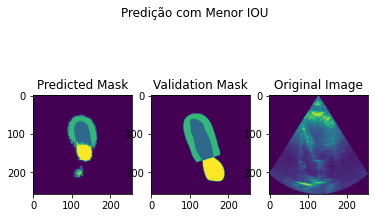

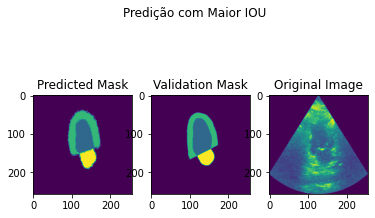

In [ ]:
from email.mime import image
import metrics

test_image_generator = camus.Camus(batch_size, img_size, input_test_images, label_test_images)

# Variáveis
ioumean = 0
dicemean = 0
total = 0
ious = []
dices = []
val_preds = []

for batch_index in range(len(test_image_generator)):
  predicted_batch = model.predict(test_image_generator[batch_index][0])
  val_preds.append(predicted_batch)

  for image_index in range(len(test_image_generator[batch_index][0])):
    total += 1
    input_image = test_image_generator[batch_index][0][image_index]
    label_image = test_image_generator[batch_index][1][image_index]

    predicted_image = predicted_batch[image_index]

    calc_iou = metrics.calc_iou_coef(label_image,predicted_image)
    calc_dice = metrics.calc_dice_coef(label_image,predicted_image)

    ious.append((calc_iou, [batch_index, image_index]))
    dices.append((calc_dice, [batch_index, image_index]))
    dicemean = dicemean + calc_dice
    ioumean = ioumean + calc_iou


# Ordena a lista de valores das métricas
ious.sort()
dices.sort()

# Calcula a média das métricas
ioumean = ioumean/total 
dicemean = dicemean/total 

metrics.my_display(ious[0][1],test_image_generator, val_preds, "Predição com Menor IOU")
metrics.my_display(ious[-1][1],test_image_generator, val_preds, "Predição com Maior IOU")
print("------------ Média das Métricas ------------")
print("Mean IoU = ", float(ioumean))
print("Mean Dice = ", float(dicemean))

## Média das metricas

In [ ]:
len(val_preds)

49

In [ ]:
from skimage.metrics import hausdorff_distance, mean_squared_error
import numpy as np
import tensorflow as tf

img1 = metrics.create_mask(img)
img1 = tf.cast(img1, dtype = tf.float32).numpy()    # altera o dtype e converte para ndarray
plt.imshow(img1)
img2 = test_image_generator.__getitem__(i)[1][0,...]             # pega a imagem do label i 
plt.figure()
plt.imshow(img2)

NameError: name 'img' is not defined

In [ ]:
from skimage.metrics import hausdorff_distance, mean_squared_error
import numpy as np
import tensorflow as tf


HD = []
f1 = []
mse = []
meaniou = []

# CALCULA A F1, MSE, HD, E MEANIOU PARA CADA PREDIÇÃO

for i,img in enumerate(val_preds):  
    img1 = metrics.create_mask(img)
    img1 = tf.cast(img1, dtype = tf.float32).numpy()    # altera o dtype e converte para ndarray
    plt.imshow(img1)
    img2 = test_image_generator.__getitem__(i)[1][0,...]             # pega a imagem do label i 
    plt.figure()
    plt.imshow(img2)
    #CALCULA AS MÉTRICAS

    HD.append(hausdorff_distance(img2,img1))
    f1.append(metrics.f1_m(img2,img1))
    mse.append(mean_squared_error(img2,img1))
    meaniou.append(metrics.mean_iou(np.expand_dims(img2, axis=0), np.expand_dims(img1, axis=0)))


# Converte tudo para ndarray
HD = np.array(HD)
f1 = np.array(f1)
mse = np.array(mse)
meaniou = np.array(meaniou)

#Printa a média das métricas
print(f'HD = {HD.mean()}, f1 = {f1.mean()}, mse = {mse.mean()}, MeanIoU = {meaniou.mean()}')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
HD = inf, f1 = 0.03474430739879608, mse = 0.9484713807397959, MeanIoU = 0.016215229406952858


## **Treinamento com Validação Cruzada**

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold
from keras.callbacks import ModelCheckpoint
import numpy as np

kfold2 = KFold(n_splits=5, shuffle=True)

prev = np.zeros(450)
target = np.array(label_images)
print(target.shape)

input_train_images = []
label_train_images = []
input_test_images = []
label_test_images = []

for idx_train, idx_val in kfold2.split(prev, target):
    for i in idx_train:
        input_train_images.append(input_images[i])
        label_train_images.append(label_images[i])

    for i in idx_val:
        input_test_images.append(input_images[i])
        label_test_images.append(label_images[i])

    train_image_generator = camus.Camus(batch_size, img_size, input_train_images, label_train_images)  
    test_image_generator  = camus.Camus(batch_size,  img_size, input_test_images, label_test_images)

    callbacks = [
      ModelCheckpoint('./checkpoint.h5', save_weights_only= True, monitor='val_loss', save_best_only=True, verbose=1, mode='min')
    ]
    model.fit(train_image_generator, epochs = 10, validation_data = test_image_generator, verbose=1, callbacks=callbacks)

    input_train_images.clear()
    label_train_images.clear()
    input_test_images.clear()
    label_test_images.clear()

(450,)
Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 2.8182 - accuracy: 0.7370
Epoch 1: val_loss improved from inf to 1.30684, saving model to .\checkpoint.h5
12/12 [==============================] - 20s 1s/step - loss: 2.8182 - accuracy: 0.7370 - val_loss: 1.3068 - val_accuracy: 0.7923
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 1.2104 - accuracy: 0.7069
Epoch 2: val_loss improved from 1.30684 to 0.99290, saving model to .\checkpoint.h5
12/12 [==============================] - 11s 956ms/step - loss: 1.2104 - accuracy: 0.7069 - val_loss: 0.9929 - val_accuracy: 0.8757
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.8591 - accuracy: 0.9451
Epoch 3: val_loss improved from 0.99290 to 0.77488, saving model to .\checkpoint.h5
12/12 [==============================] - 7s 541ms/step - loss: 0.8591 - accuracy: 0.9451 - val_loss: 0.7749 - val_accuracy: 0.9832
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.6

## **Predição - Validação Cruzada**

In [ ]:
# Carrega os pesos gerados em um treinamento prévio
model.load_weights('cross_validation.h5')

------------ Média das Métricas ------------
Mean IoU =  0.9711381428818997
Mean Dice =  0.9853542532370285


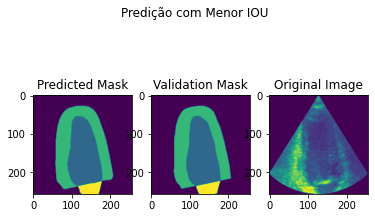

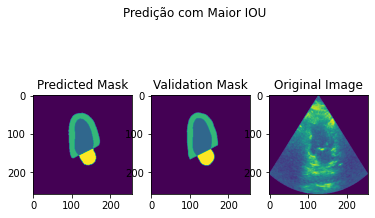

In [ ]:
from email.mime import image
import metrics

input_train_images, input_test_images, label_train_images, label_test_images = train_test_split(
    input_images, label_images, test_size=test_size, random_state=444)
test_image_generator = camus.Camus(batch_size, img_size, input_test_images, label_test_images)

# Variáveis
ioumean = 0
dicemean = 0
total = 0
ious = []
dices = []
val_preds = []

for batch_index in range(len(test_image_generator)):
  predicted_batch = model.predict(test_image_generator[batch_index][0])
  val_preds.append(predicted_batch)

  for image_index in range(len(test_image_generator[batch_index][0])):
    total += 1
    input_image = test_image_generator[batch_index][0][image_index]
    label_image = test_image_generator[batch_index][1][image_index]

    predicted_image = predicted_batch[image_index]

    calc_iou = metrics.calc_iou_coef(label_image,predicted_image)
    calc_dice = metrics.calc_dice_coef(label_image,predicted_image)

    ious.append((calc_iou, [batch_index, image_index]))
    dices.append((calc_dice, [batch_index, image_index]))
    dicemean = dicemean + calc_dice
    ioumean = ioumean + calc_iou


# Ordena a lista de valores das métricas
ious.sort()
dices.sort()

# Calcula a média das métricas
ioumean = ioumean/total 
dicemean = dicemean/total 

metrics.my_display(ious[0][1],test_image_generator, val_preds, "Predição com Menor IOU")
metrics.my_display(ious[-1][1],test_image_generator, val_preds, "Predição com Maior IOU")
print("------------ Média das Métricas ------------")
print("Mean IoU = ", float(ioumean))
print("Mean Dice = ", float(dicemean))

### **Adicionar:**
* Métrica da distância de Hausdorff (tem no tensorflow)
* ~~Métrica do coeficiente de Dice (dá pra pegar os true e false positive e negative e calcular na mão)~~
* ~~Explicar o dataset e o que queremos fazer lá no começo~~
* Comparar nossos resultados (nossas métricas) com os artigos que usamos como referência
* ~~Exibir as imagens bonitinhas (dando display mesmo) pra apresentação~~

# Comparação dos resultados

Em nossas referências, 5 artigos utilizaram variações da U-Net no dataset CAMUS. A métrica comum entre eles é o coeficiente Dice. Seus resultados foram:

* 97% - [Echocardiographic image segmentation using deep Res-U network](https://www.sciencedirect.com/science/article/pii/S1746809420303761?casa_token=9hG0u9p6ZW8AAAAA:Pdn-8V1ALTsj765bXAcWeVbsgF8OTXGbakkgphbVRb0ucO1bxoonPHZbN96uOuZJu0NZrKn29A)
* 93% - [Left ventricular and atrial segmentation of 2D echocardiography with convolutional neural networks](https://www.spiedigitallibrary.org/conference-proceedings-of-spie/11313/113130A/Left-ventricular-and-atrial-segmentation-of-2D-echocardiography-with-convolutional/10.1117/12.2547375.short?SSO=1)
* 85% [MCAL: An Anatomical Knowledge Learning
Model for Myocardial Segmentation
in 2-D Echocardiography](https://ieeexplore.ieee.org/abstract/document/9714298/?casa_token=fSucjTTX1XQAAAAA:n-iUybCr_-NiO9vPckWy1v4jB6MiWkvbUShiZKkEiTZ699vqyUIDC1blNkARziXpAN-nHHQpDw)
* 95% - [MFP-Unet: A novel deep learning based approach for left ventricle segmentation in echocardiography](https://www.sciencedirect.com/science/article/pii/S1120179719304508?casa_token=khB7nT4tsXkAAAAA:fN6geVXUNbf1ISi0y5xzEbLUAfYR0I1toUsdk4QtxY7Zm9NGJuCT_7YGwoXcMgjFd2zRrp_5ng)
* 92% - [Assessing the generalizability of temporally coherent echocardiography video segmentation](https://www.spiedigitallibrary.org/conference-proceedings-of-spie/11596/115961O/Assessing-the-generalizability-of-temporally-coherent-echocardiography-video-segmentation/10.1117/12.2580874.short)

Por conta do nosso escopo limitado, não realizamos a aumentação de dados que alguns desses artigos fizeram. Também optamos por utilizar somente a U-Net padrão, inicialmente com as configurações descritas em [Segmentation of Left Ventricle in 2D echocardiography using deep learning](https://link.springer.com/chapter/10.1007/978-3-030-39343-4_43), que comparava diferentes técnicas de segmentação, com a U-Net possuindo Dice de 93% e IoU de 98%, porém com um dataset diferente do CAMUS. Nós superamos esses valores com um Dice de 98% e IoU de 97%, um resultado mais que satisfatório para o escopo que estamos lidando.